##Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline

In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

##Settings and Device

In [3]:
randomSeed = 1
batchSize = 100
numEpochs = 100


In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


##DataLoader

In [5]:
trainDataset = datasets.MNIST(root='data',
                              train=True,
                              transform=transforms.ToTensor(),
                              download = True)

testDataset = datasets.MNIST(root='data',
                             train=False,
                             transform=transforms.ToTensor())

trainLoader = DataLoader(dataset=trainDataset,
                         batch_size=batchSize,
                         shuffle=True)


testLoader = DataLoader(dataset=trainDataset,
                         batch_size=batchSize,
                         shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 76574584.57it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33024998.32it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20474786.24it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11510893.52it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
for images,labels in trainLoader:
  print('Image batch dim',images.shape)
  print('Label batch dim',labels.shape)
  break

Image batch dim torch.Size([100, 1, 28, 28])
Label batch dim torch.Size([100])


##One Hot Encoding

In [7]:
def toOneHot(y,nClasses):
  yOneHot = torch.FloatTensor(y.size(0),nClasses)
  yOneHot.zero_()
  tmp = y.view(-1,1).long().to(torch.device('cpu'))
  yOneHot.scatter_(1,tmp,1).float()
  return yOneHot

##Model

In [8]:
class mlpSoftmax(torch.nn.Module):

  def __init__(self,numFeatures,numHidden,numClasses):
    super(mlpSoftmax,self).__init__()

    self.numClasses = numClasses

    self.linearLayer = torch.nn.Linear(numFeatures,numHidden)
    self.linearLayer.weight.detach().normal_(0,0.1)
    self.linearLayer.bias.detach().normal_(0)

    self.linearOut = torch.nn.Linear(numHidden,numClasses)
    self.linearOut.weight.detach().normal_(0,0.1)
    self.linearOut.bias.detach().normal_(0)

  def forward(self,x):
    out = self.linearLayer(x)
    out = torch.sigmoid(out)
    logits = self.linearOut(out)
    return logits



##Model Initialization

In [9]:
torch.manual_seed(randomSeed)


In [10]:
model = mlpSoftmax(numFeatures=784,numHidden=100,numClasses=10)
model.to(DEVICE)

mlpSoftmax(
  (linearLayer): Linear(in_features=784, out_features=100, bias=True)
  (linearOut): Linear(in_features=100, out_features=10, bias=True)
)

In [11]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.1, weight_decay=0.001)

In [12]:
def computeLoss(net,dataLoader):
  totalLoss = 0.
  with torch.no_grad():
      for cnt , (features,targets) in enumerate(dataLoader):
        features = features.view(-1,28*28)
        # targets = targets.view(-1).float()
        targets = toOneHot(targets,net.numClasses)
        logits = model(features)
        loss = F.cross_entropy(logits,targets)
        totalLoss+=loss
      return totalLoss/cnt

##Training

In [13]:
startTime = time.time()
miniBatchCost = []
epochCost = []
for e in range(numEpochs):
  model.train()
  for batchIDx, (features,targets) in enumerate(trainLoader):
    features = features.view(-1,28*28)
    # targets = targets.view(-1).float()
    targets = toOneHot(targets,model.numClasses)
    logits = model(features)
    cost = F.cross_entropy(logits,targets)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    miniBatchCost.append(cost.item())
    if(not batchIDx % 50):
      print("Epoch %03d/%03d | Batch %03d/%03d | Cost: %.4f" % (e+1,numEpochs,batchIDx,len(trainLoader),cost.item()))
  epoCost = computeLoss(model,trainLoader)
  print("Epoch %03d/%03d | Cost: %.4f" % (e+1,numEpochs,epoCost))
  print("Time: %.2f min" %((time.time()-startTime)/60))
  epochCost.append(epoCost)
print("Total Time: %.2f min" %((time.time()-startTime)/60))




Epoch 001/100 | Batch 000/600 | Cost: 2.5581
Epoch 001/100 | Batch 050/600 | Cost: 1.9779
Epoch 001/100 | Batch 100/600 | Cost: 1.5658
Epoch 001/100 | Batch 150/600 | Cost: 1.1957
Epoch 001/100 | Batch 200/600 | Cost: 0.9430
Epoch 001/100 | Batch 250/600 | Cost: 0.8211
Epoch 001/100 | Batch 300/600 | Cost: 0.6760
Epoch 001/100 | Batch 350/600 | Cost: 0.6817
Epoch 001/100 | Batch 400/600 | Cost: 0.6896
Epoch 001/100 | Batch 450/600 | Cost: 0.5225
Epoch 001/100 | Batch 500/600 | Cost: 0.4556
Epoch 001/100 | Batch 550/600 | Cost: 0.5627
Epoch 001/100 | Cost: 0.5162
Time: 0.27 min
Epoch 002/100 | Batch 000/600 | Cost: 0.5231
Epoch 002/100 | Batch 050/600 | Cost: 0.4530
Epoch 002/100 | Batch 100/600 | Cost: 0.3777
Epoch 002/100 | Batch 150/600 | Cost: 0.5530
Epoch 002/100 | Batch 200/600 | Cost: 0.5343
Epoch 002/100 | Batch 250/600 | Cost: 0.3863
Epoch 002/100 | Batch 300/600 | Cost: 0.4939
Epoch 002/100 | Batch 350/600 | Cost: 0.5084
Epoch 002/100 | Batch 400/600 | Cost: 0.4089
Epoch 002/1

##Evaluation

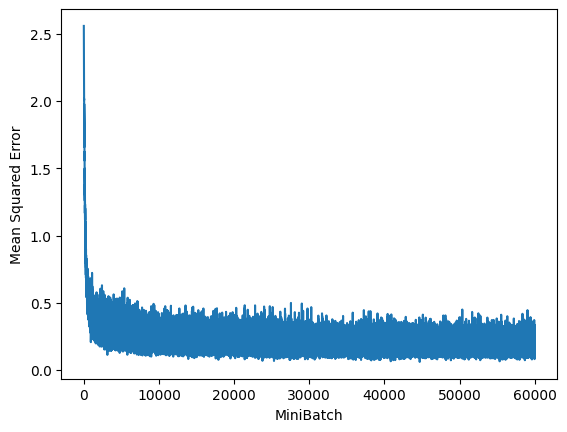

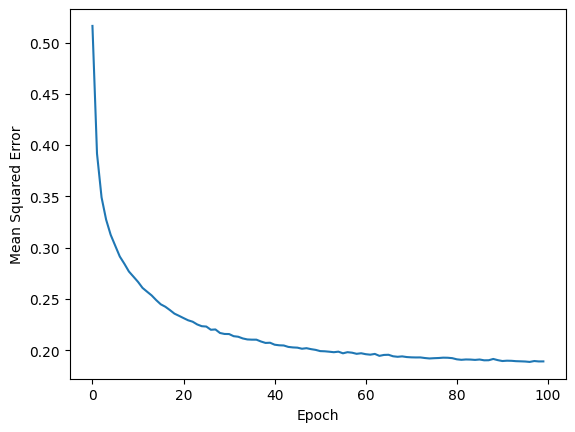

In [14]:
plt.plot(range(len(miniBatchCost)),miniBatchCost)
plt.ylabel("Mean Squared Error")
plt.xlabel("MiniBatch")
plt.show()

plt.plot(range(len(epochCost)),epochCost)
plt.ylabel("Mean Squared Error")
plt.xlabel("Epoch")
plt.show()

In [15]:
def computeAcc(net,dataLoader):
  correctPred,numExamples = 0 , 0
  with torch.no_grad():
    for features,targets in dataLoader:
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
        logits = net.forward(features)
        pred = torch.argmax(logits, 1)
#         num_examples += targets.size(0)
        numExamples+=targets.size(0)
        correctPred+=(pred==targets).sum()
      # yOneHot = toOneHot(targets,model.numClasses)
      # loss = torch.sum((yOneHot - probas)**2, dim=0)
      # numExamples+=targets.size(0)
      # currMSE+=loss
    # currMSE = torch.mean(currMSE/numExamples, dim=0)
    return correctPred.float()/numExamples * 100


In [16]:
print("Training Accuracy :%.2f" % (computeAcc(model,trainLoader)))
print("Testing  Accuracy :%.2f" % (computeAcc(model,testLoader )))


Training Accuracy :95.31
Testing  Accuracy :95.31
